In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings('ignore')


In [20]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

print("="*80)
print("STEP 9: GENERATING VISUALIZATIONS FOR THESIS")
print("="*80)

STEP 9: GENERATING VISUALIZATIONS FOR THESIS


In [22]:
OUTPUT_DIR = '/home/kali/AI/'

df_features = pd.read_csv(OUTPUT_DIR + 'fcm_features_raw.csv', index_col=0)
cluster_labels = np.load(OUTPUT_DIR + 'fcm_cluster_labels_c2.npy')
membership_matrix = np.load(OUTPUT_DIR + 'fcm_membership_c2.npy')

df_features['Cluster'] = cluster_labels
provinces = df_features.index.tolist()

# Feature groups
feature_groups = {
    'Mean': [c for c in df_features.columns if c.startswith('Mean_')],
    'CV': [c for c in df_features.columns if c.startswith('CV_')],
    'Trend': [c for c in df_features.columns if c.startswith('Trend_')],
    'Autocorr': [c for c in df_features.columns if c.startswith('Autocorr_')],
    'Skewness': [c for c in df_features.columns if c.startswith('Skewness_')]
}

# Determine high-risk cluster
c0_cv = df_features[df_features['Cluster']==0][feature_groups['CV']].mean().mean()
c1_cv = df_features[df_features['Cluster']==1][feature_groups['CV']].mean().mean()
high_risk_cluster = 0 if c0_cv > c1_cv else 1

print(f"\n✓ Data loaded")
print(f"✓ High-risk cluster: {high_risk_cluster} (CV={c0_cv if high_risk_cluster==0 else c1_cv:.4f})")
print(f"✓ Low-risk cluster: {1-high_risk_cluster} (CV={c1_cv if high_risk_cluster==0 else c0_cv:.4f})")



✓ Data loaded
✓ High-risk cluster: 1 (CV=0.1314)
✓ Low-risk cluster: 0 (CV=0.0981)



[1/7] Generating cluster distribution pie chart...


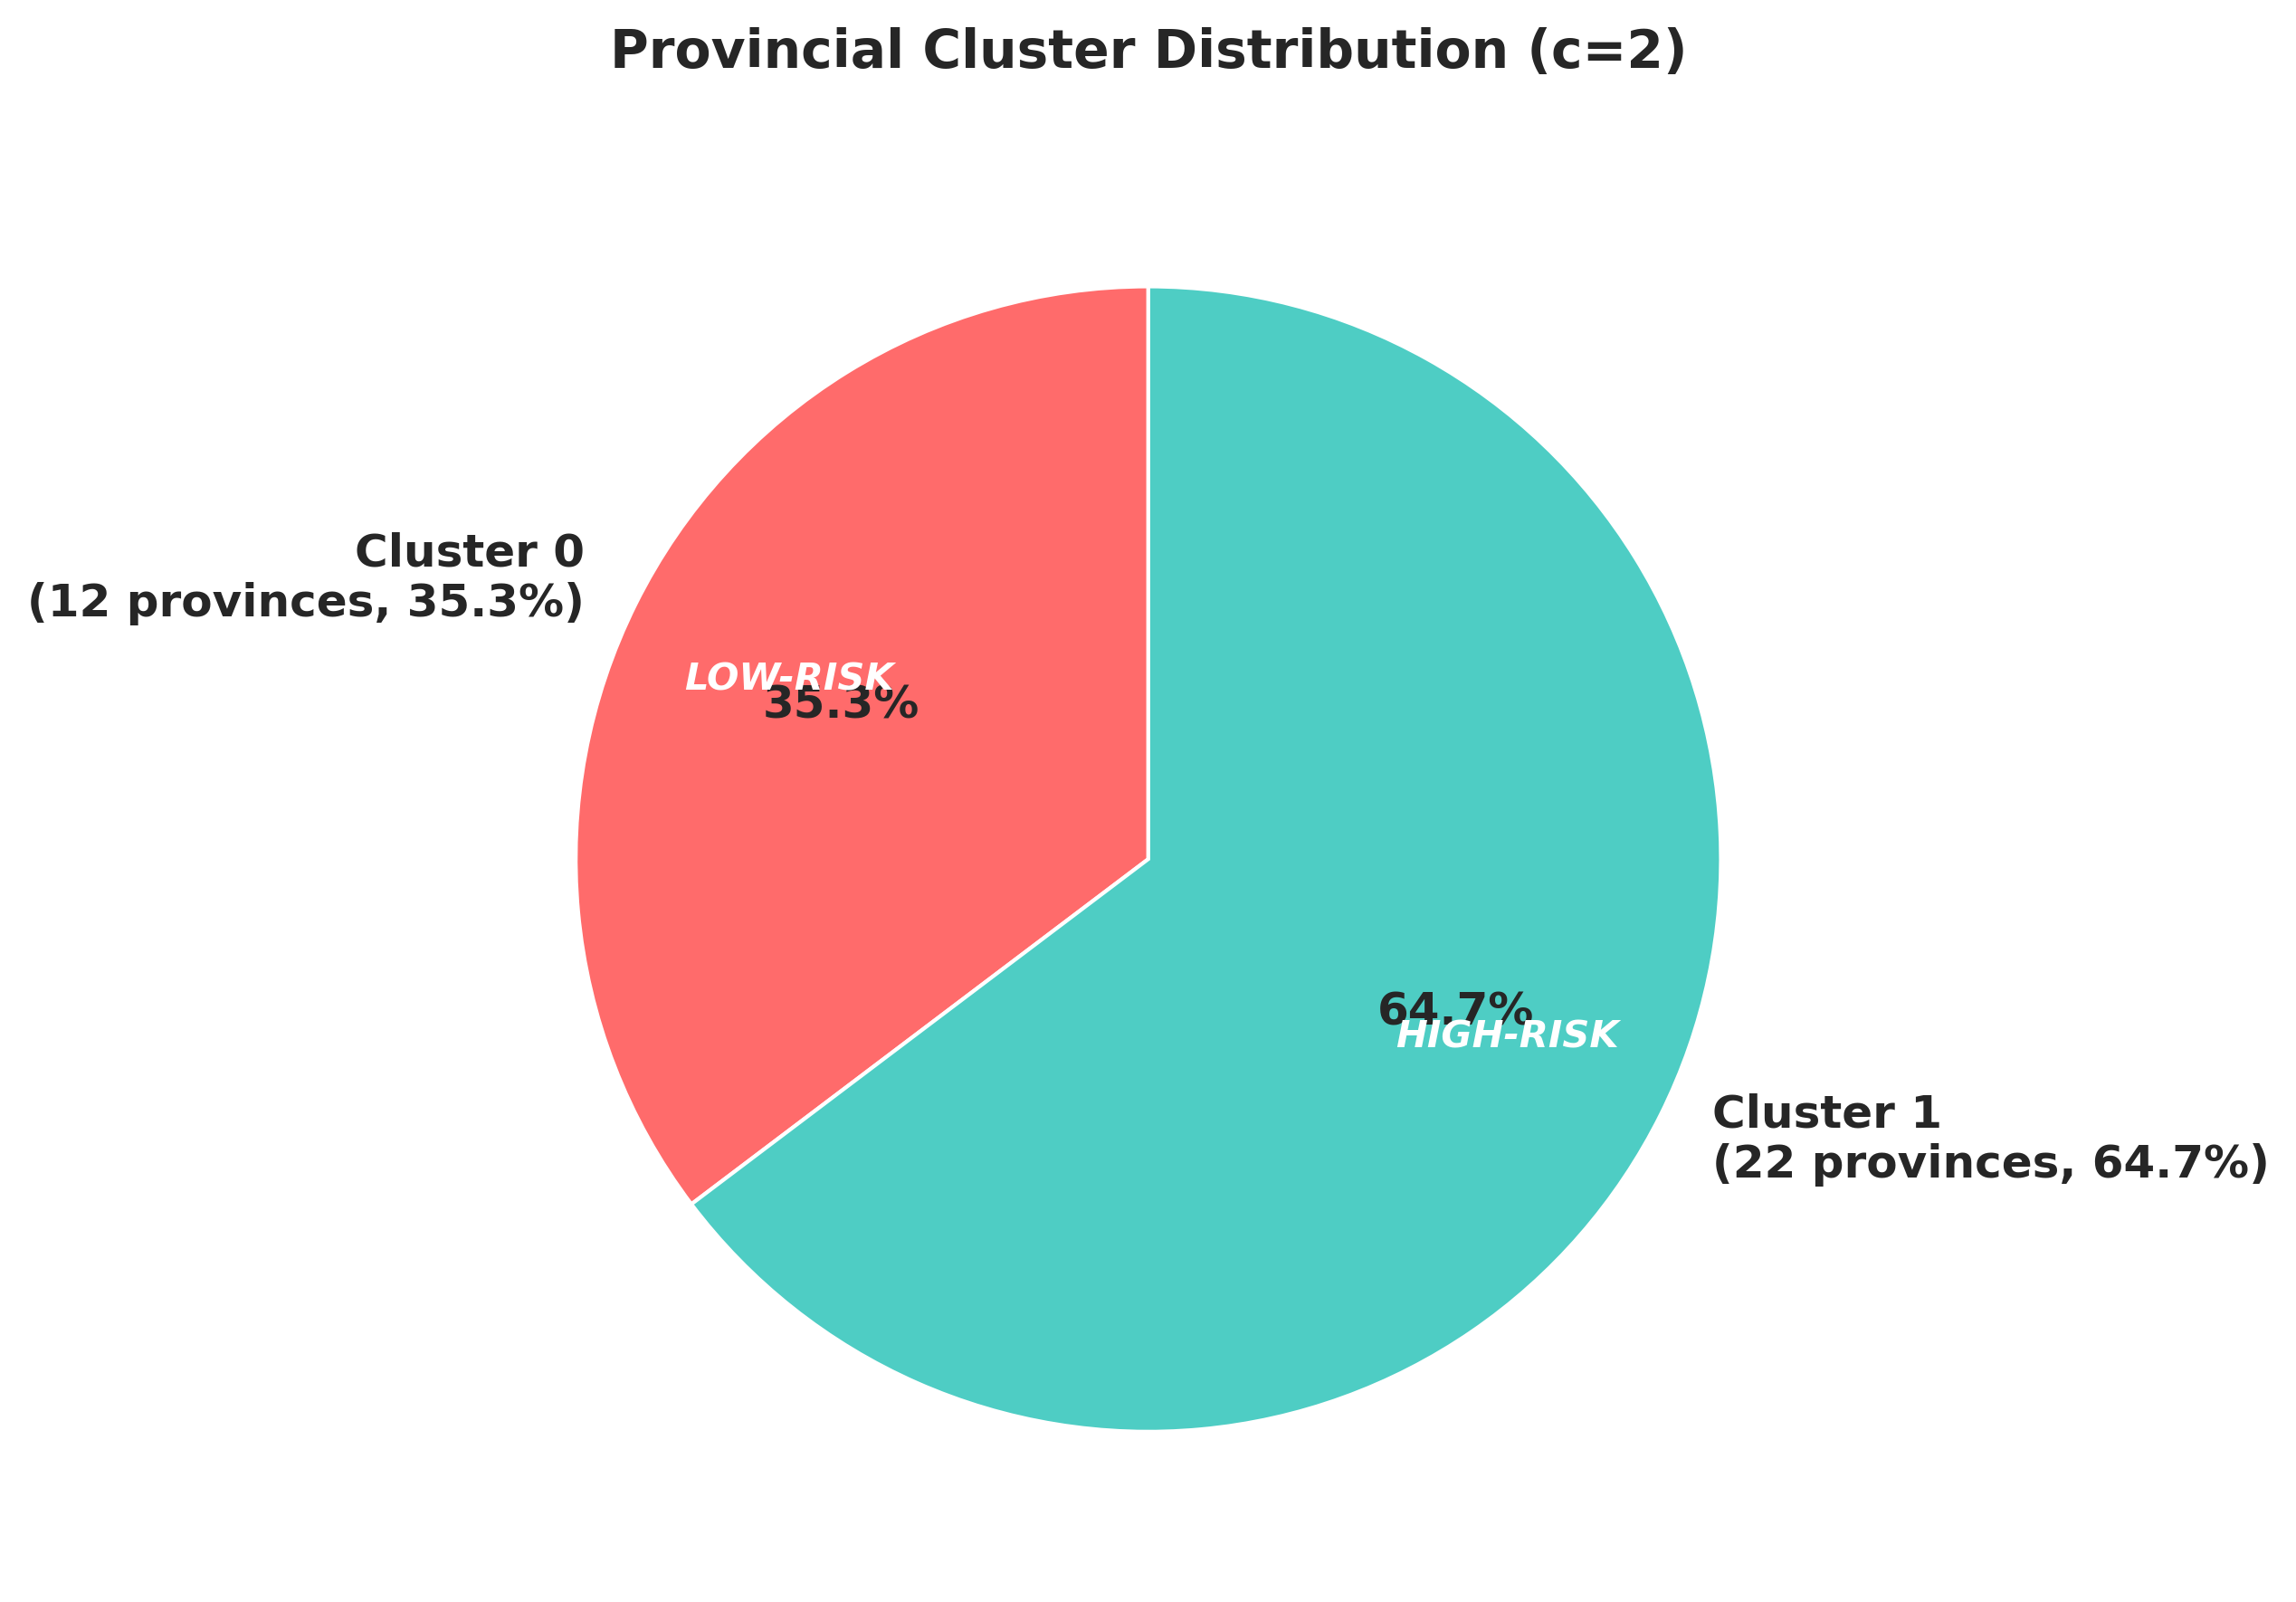

  ✓ Saved: viz_1_cluster_distribution.png


In [26]:
# ============================================================================
# VISUALIZATION 1: CLUSTER DISTRIBUTION (PIE CHART)
# ============================================================================
print("\n[1/7] Generating cluster distribution pie chart...")

fig, ax = plt.subplots(figsize=(8, 6))

cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
colors = ['#ff6b6b', '#4ecdc4']  # Red for high-risk, Teal for low-risk
labels = [f'Cluster {i}\n({cluster_counts[i]} provinces, {cluster_counts[i]/34*100:.1f}%)' 
          for i in [0, 1]]

wedges, texts, autotexts = ax.pie(
    cluster_counts, 
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 12, 'weight': 'bold'}
)

# Add risk labels
risk_labels = ['HIGH-RISK' if i == high_risk_cluster else 'LOW-RISK' for i in [0, 1]]
for i, (wedge, label) in enumerate(zip(wedges, risk_labels)):
    angle = (wedge.theta2 + wedge.theta1) / 2
    x = 0.7 * np.cos(np.radians(angle))
    y = 0.7 * np.sin(np.radians(angle))
    ax.text(x, y, label, ha='center', va='center', 
            fontsize=10, style='italic', color='white', weight='bold')

ax.set_title('Provincial Cluster Distribution (c=2)', fontsize=14, weight='bold', pad=20)
plt.tight_layout()
plt.show()
plt.savefig(OUTPUT_DIR + 'viz_1_cluster_distribution.png', dpi=300, bbox_inches='tight')
print(f"  ✓ Saved: viz_1_cluster_distribution.png")
plt.close()


[2/7] Generating feature comparison boxplots...


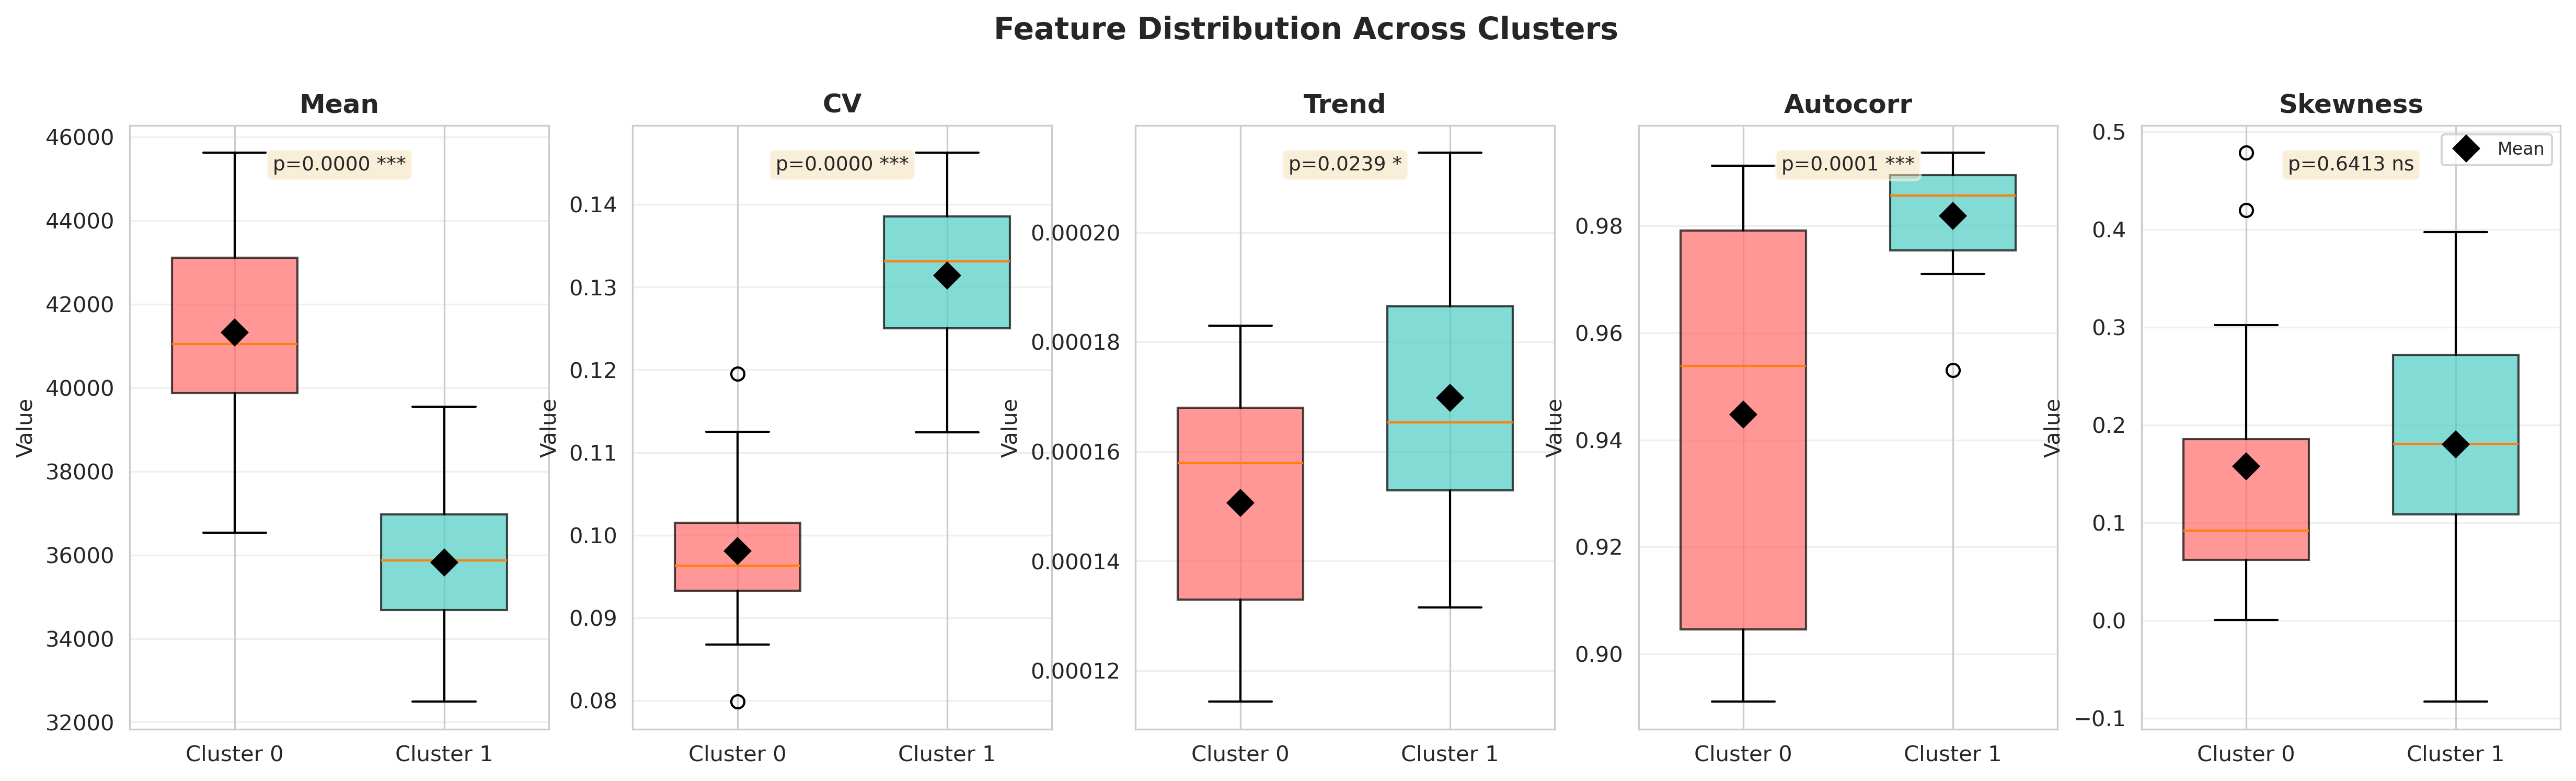

  ✓ Saved: viz_2_feature_comparison.png


In [25]:
# ============================================================================
# VISUALIZATION 2: FEATURE COMPARISON (BOX PLOTS)
# ============================================================================
print("\n[2/7] Generating feature comparison boxplots...")

fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for i, (ftype, cols) in enumerate(feature_groups.items()):
    ax = axes[i]
    
    # Prepare data for boxplot
    data_c0 = df_features[df_features['Cluster']==0][cols].mean(axis=1).values
    data_c1 = df_features[df_features['Cluster']==1][cols].mean(axis=1).values
    
    bp = ax.boxplot(
        [data_c0, data_c1],
        labels=['Cluster 0', 'Cluster 1'],
        patch_artist=True,
        widths=0.6
    )
    
    # Color boxes
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    # Add mean markers
    ax.plot([1, 2], [data_c0.mean(), data_c1.mean()], 
            'D', color='black', markersize=8, label='Mean', zorder=3)
    
    ax.set_title(ftype, fontsize=12, weight='bold')
    ax.set_ylabel('Value', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add statistical significance
    from scipy import stats
    t_stat, p_val = stats.ttest_ind(data_c0, data_c1)
    sig_text = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
    ax.text(0.5, 0.95, f'p={p_val:.4f} {sig_text}', 
            transform=ax.transAxes, ha='center', va='top',
            fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[4].legend(loc='upper right', fontsize=8)
plt.suptitle('Feature Distribution Across Clusters', fontsize=14, weight='bold', y=1.02)
plt.show()
plt.tight_layout()
plt.savefig(OUTPUT_DIR + 'viz_2_feature_comparison.png', dpi=300, bbox_inches='tight')
print(f"  ✓ Saved: viz_2_feature_comparison.png")
plt.close()



[3/7] Generating cluster profile radar chart...


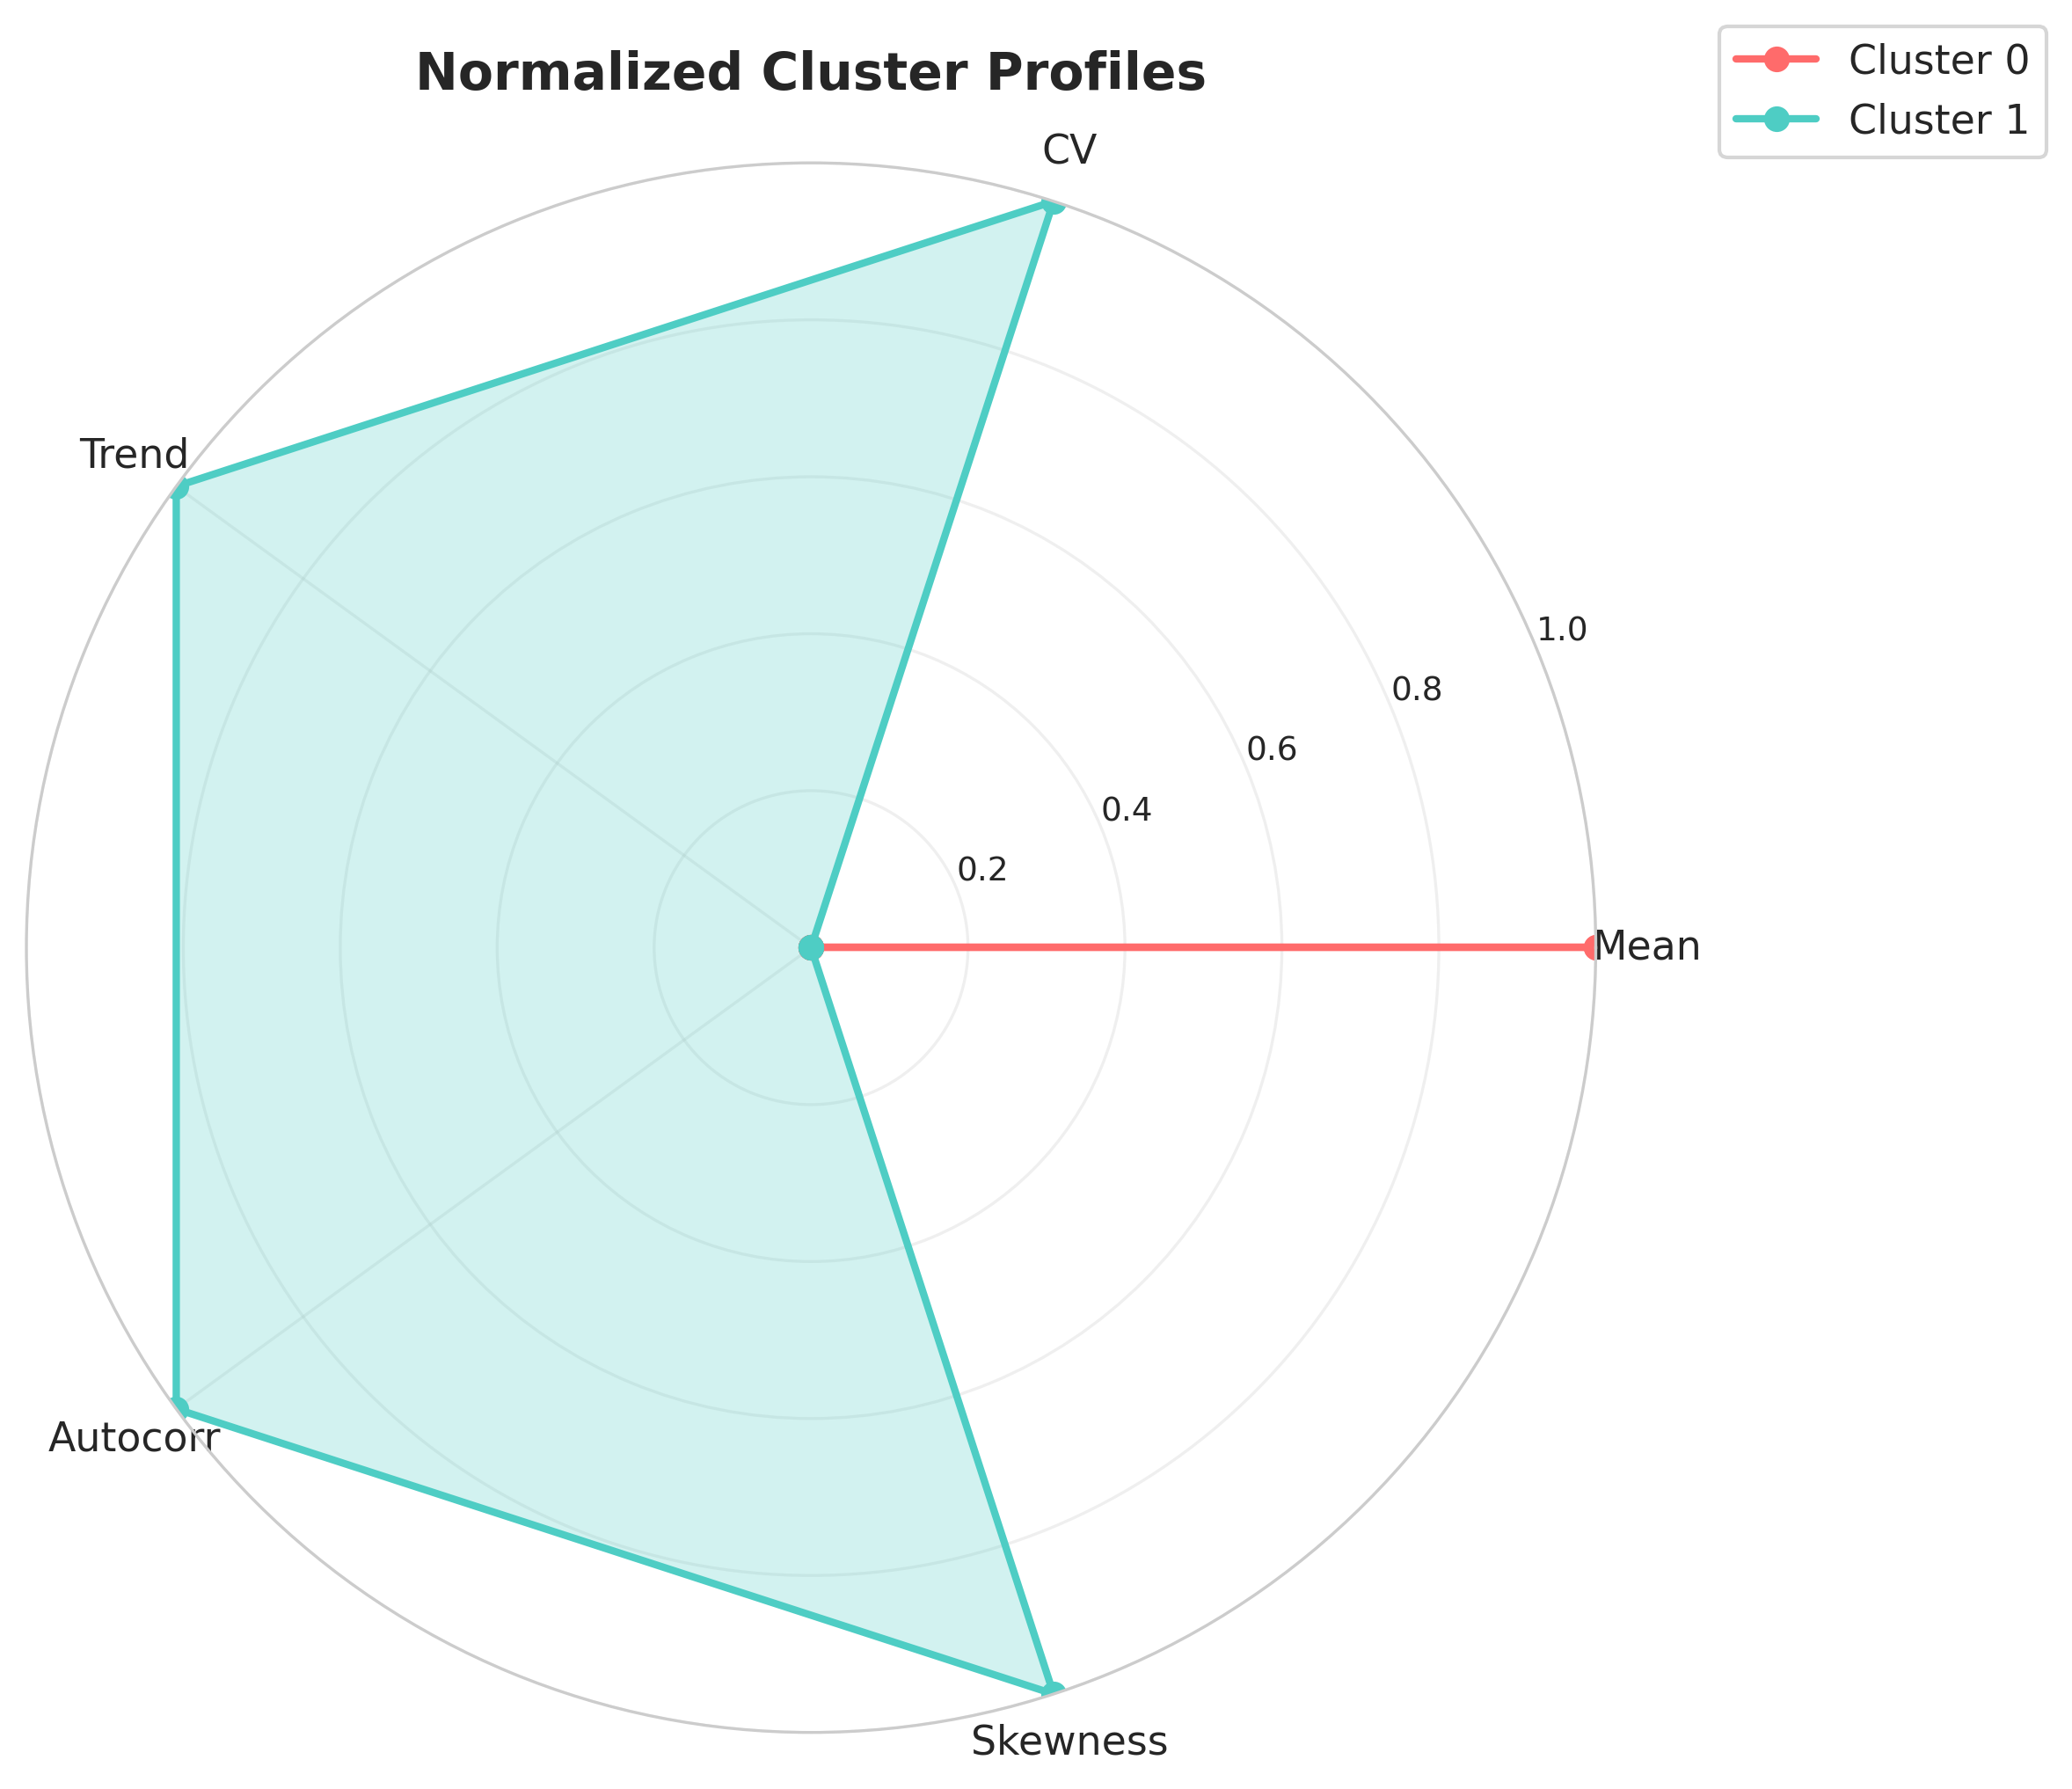

  ✓ Saved: viz_3_cluster_radar.png


In [28]:
print("\n[3/7] Generating cluster profile radar chart...")

from math import pi

# Calculate normalized profiles (0-1 scale)
profile_data = []
for c_id in [0, 1]:
    cluster_df = df_features[df_features['Cluster'] == c_id]
    profile = {}
    for ftype, cols in feature_groups.items():
        profile[ftype] = cluster_df[cols].mean().mean()
    profile_data.append(profile)

# Normalize to 0-1 scale
df_profile = pd.DataFrame(profile_data, index=['Cluster 0', 'Cluster 1'])
df_profile_norm = (df_profile - df_profile.min()) / (df_profile.max() - df_profile.min())

# Radar chart
categories = list(feature_groups.keys())
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))

for i, cluster in enumerate(['Cluster 0', 'Cluster 1']):
    values = df_profile_norm.loc[cluster].values.tolist()
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=cluster, color=colors[i])
    ax.fill(angles, values, alpha=0.25, color=colors[i])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=11)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], fontsize=9)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=11)
ax.set_title('Normalized Cluster Profiles', fontsize=14, weight='bold', pad=20)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig(OUTPUT_DIR + 'viz_3_cluster_radar.png', dpi=300, bbox_inches='tight')
print(f"  ✓ Saved: viz_3_cluster_radar.png")
plt.close()



[4/7] Generating fuzzy membership distribution...


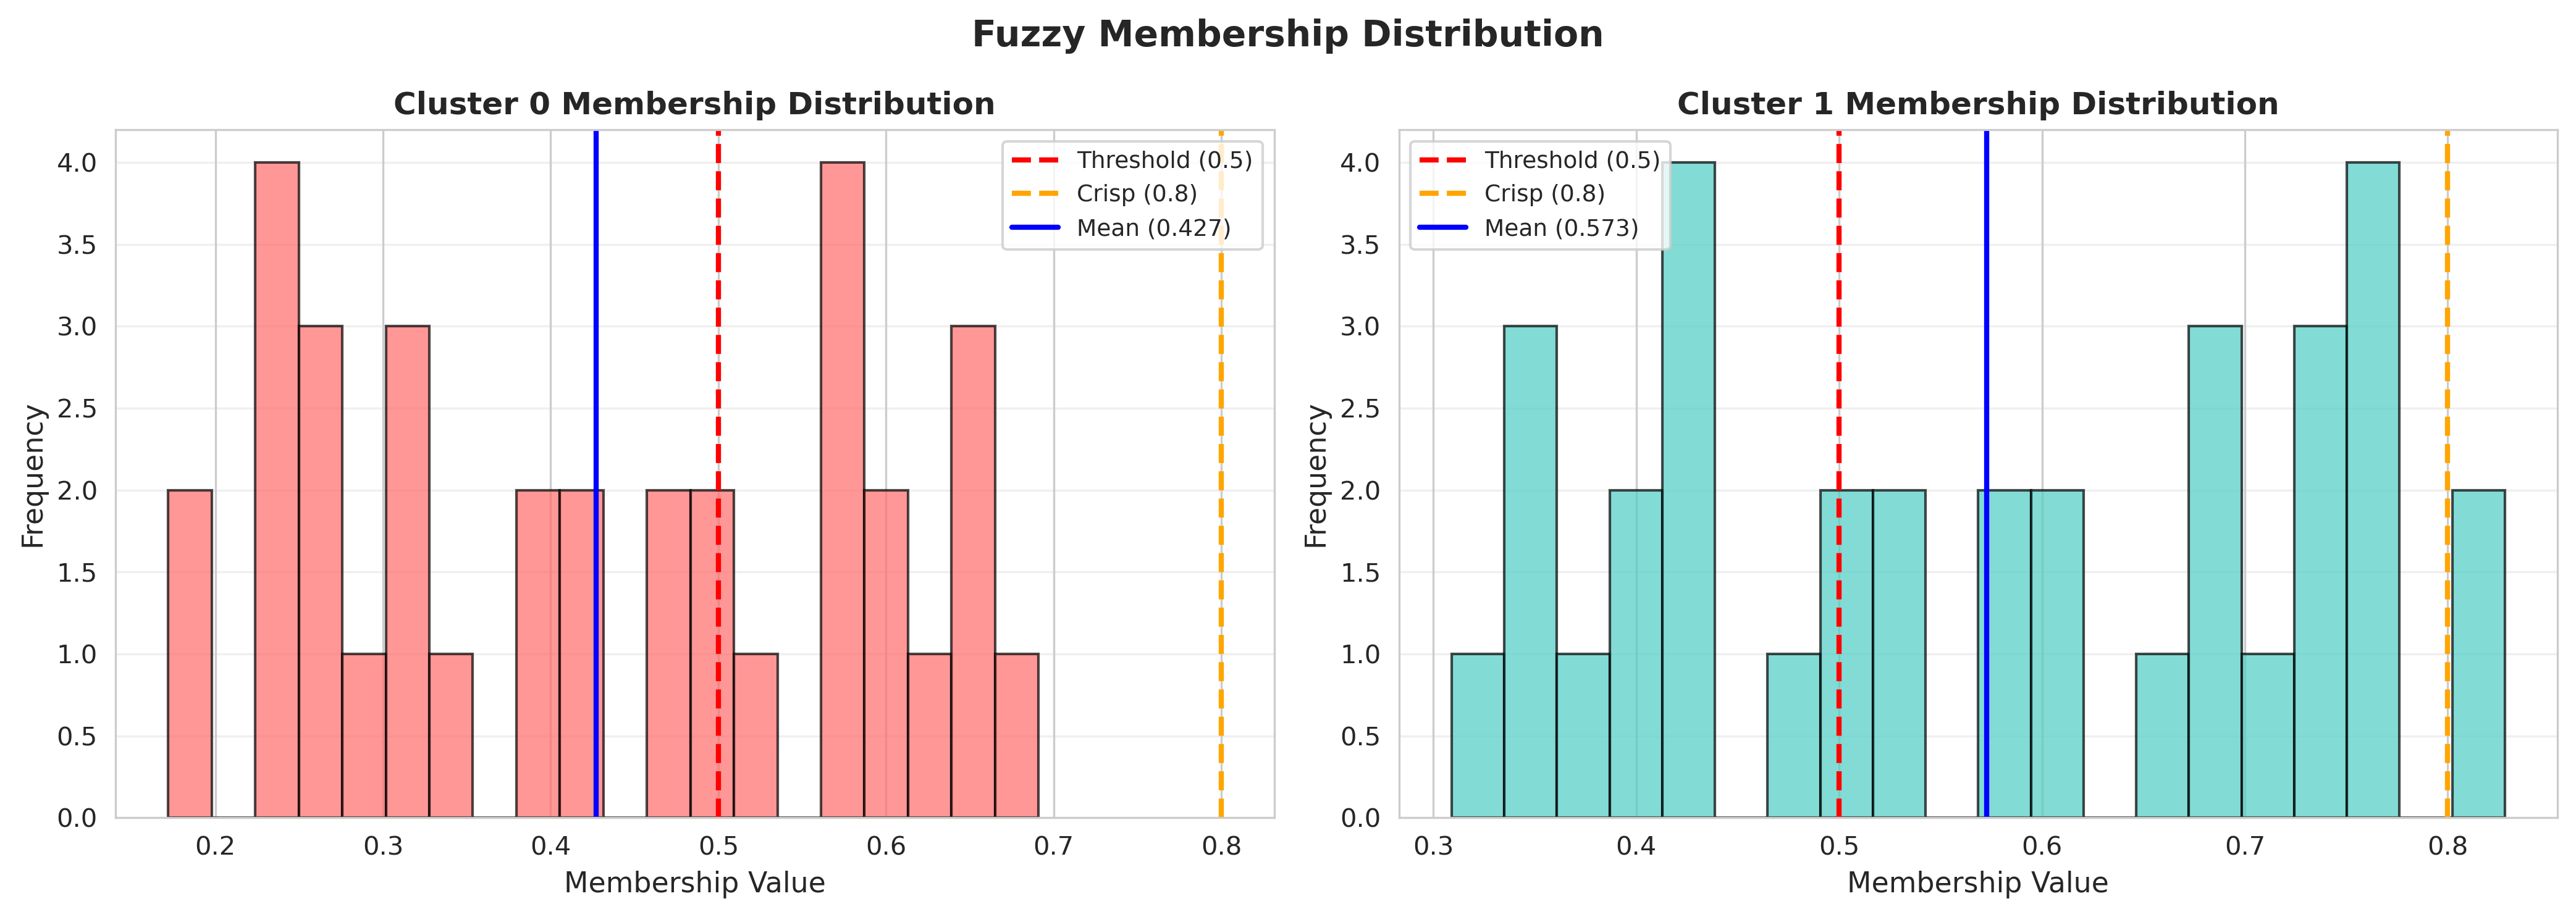

  ✓ Saved: viz_4_membership_distribution.png


In [30]:
print("\n[4/7] Generating fuzzy membership distribution...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for c_id in [0, 1]:
    ax = axes[c_id]
    
    memberships = membership_matrix[c_id, :]
    
    # Histogram
    ax.hist(memberships, bins=20, color=colors[c_id], alpha=0.7, edgecolor='black')
    
    # Add vertical lines for thresholds
    ax.axvline(0.5, color='red', linestyle='--', linewidth=2, label='Threshold (0.5)')
    ax.axvline(0.8, color='orange', linestyle='--', linewidth=2, label='Crisp (0.8)')
    
    # Statistics
    ax.axvline(memberships.mean(), color='blue', linestyle='-', linewidth=2, label=f'Mean ({memberships.mean():.3f})')
    
    ax.set_xlabel('Membership Value', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.set_title(f'Cluster {c_id} Membership Distribution', fontsize=12, weight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Fuzzy Membership Distribution', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()
plt.savefig(OUTPUT_DIR + 'viz_4_membership_distribution.png', dpi=300, bbox_inches='tight')
print(f"  ✓ Saved: viz_4_membership_distribution.png")
plt.close()


[5/7] Generating crisp vs fuzzy assignment bar chart...


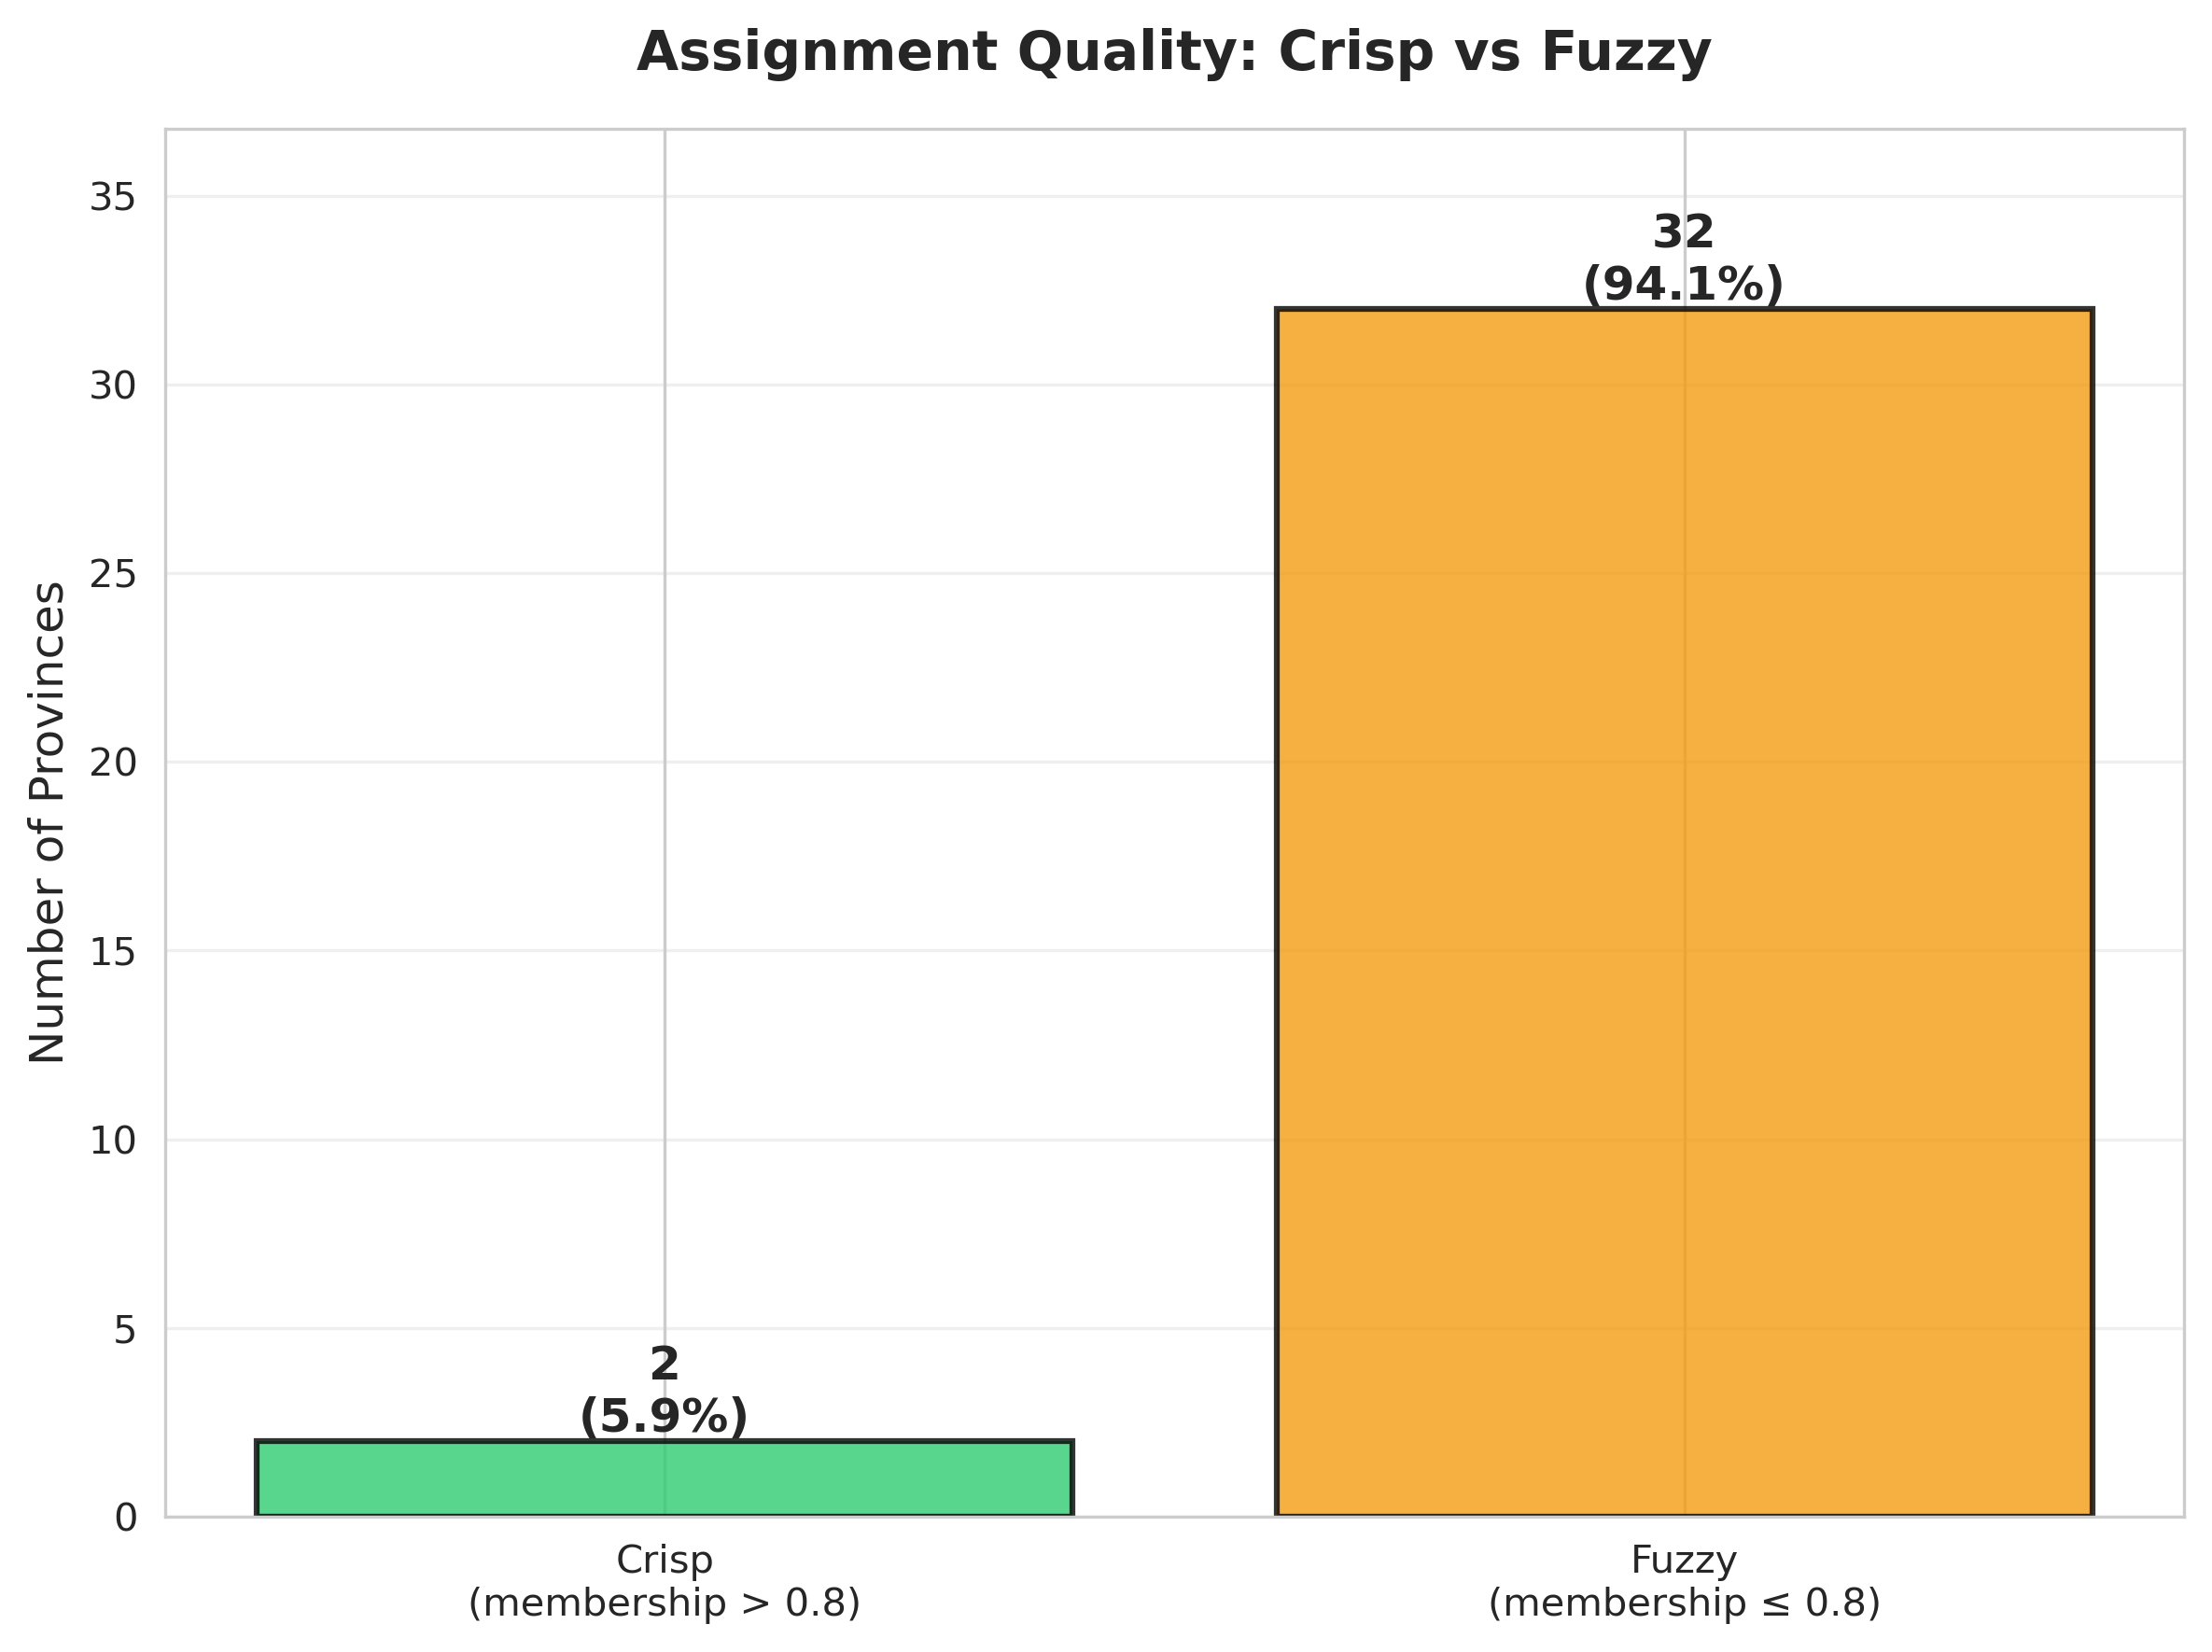

  ✓ Saved: viz_5_crisp_fuzzy.png


In [32]:
print("\n[5/7] Generating crisp vs fuzzy assignment bar chart...")

max_memberships = membership_matrix.max(axis=0)
crisp_count = (max_memberships > 0.8).sum()
fuzzy_count = (max_memberships <= 0.8).sum()

fig, ax = plt.subplots(figsize=(8, 6))

categories = ['Crisp\n(membership > 0.8)', 'Fuzzy\n(membership ≤ 0.8)']
counts = [crisp_count, fuzzy_count]
colors_bar = ['#2ecc71', '#f39c12']

bars = ax.bar(categories, counts, color=colors_bar, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{count}\n({count/34*100:.1f}%)',
            ha='center', va='bottom', fontsize=12, weight='bold')

ax.set_ylabel('Number of Provinces', fontsize=12)
ax.set_title('Assignment Quality: Crisp vs Fuzzy', fontsize=14, weight='bold', pad=15)
ax.set_ylim(0, max(counts) * 1.15)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()
plt.savefig(OUTPUT_DIR + 'viz_5_crisp_fuzzy.png', dpi=300, bbox_inches='tight')
print(f"  ✓ Saved: viz_5_crisp_fuzzy.png")
plt.close()


[6/7] Generating province-cluster mapping...


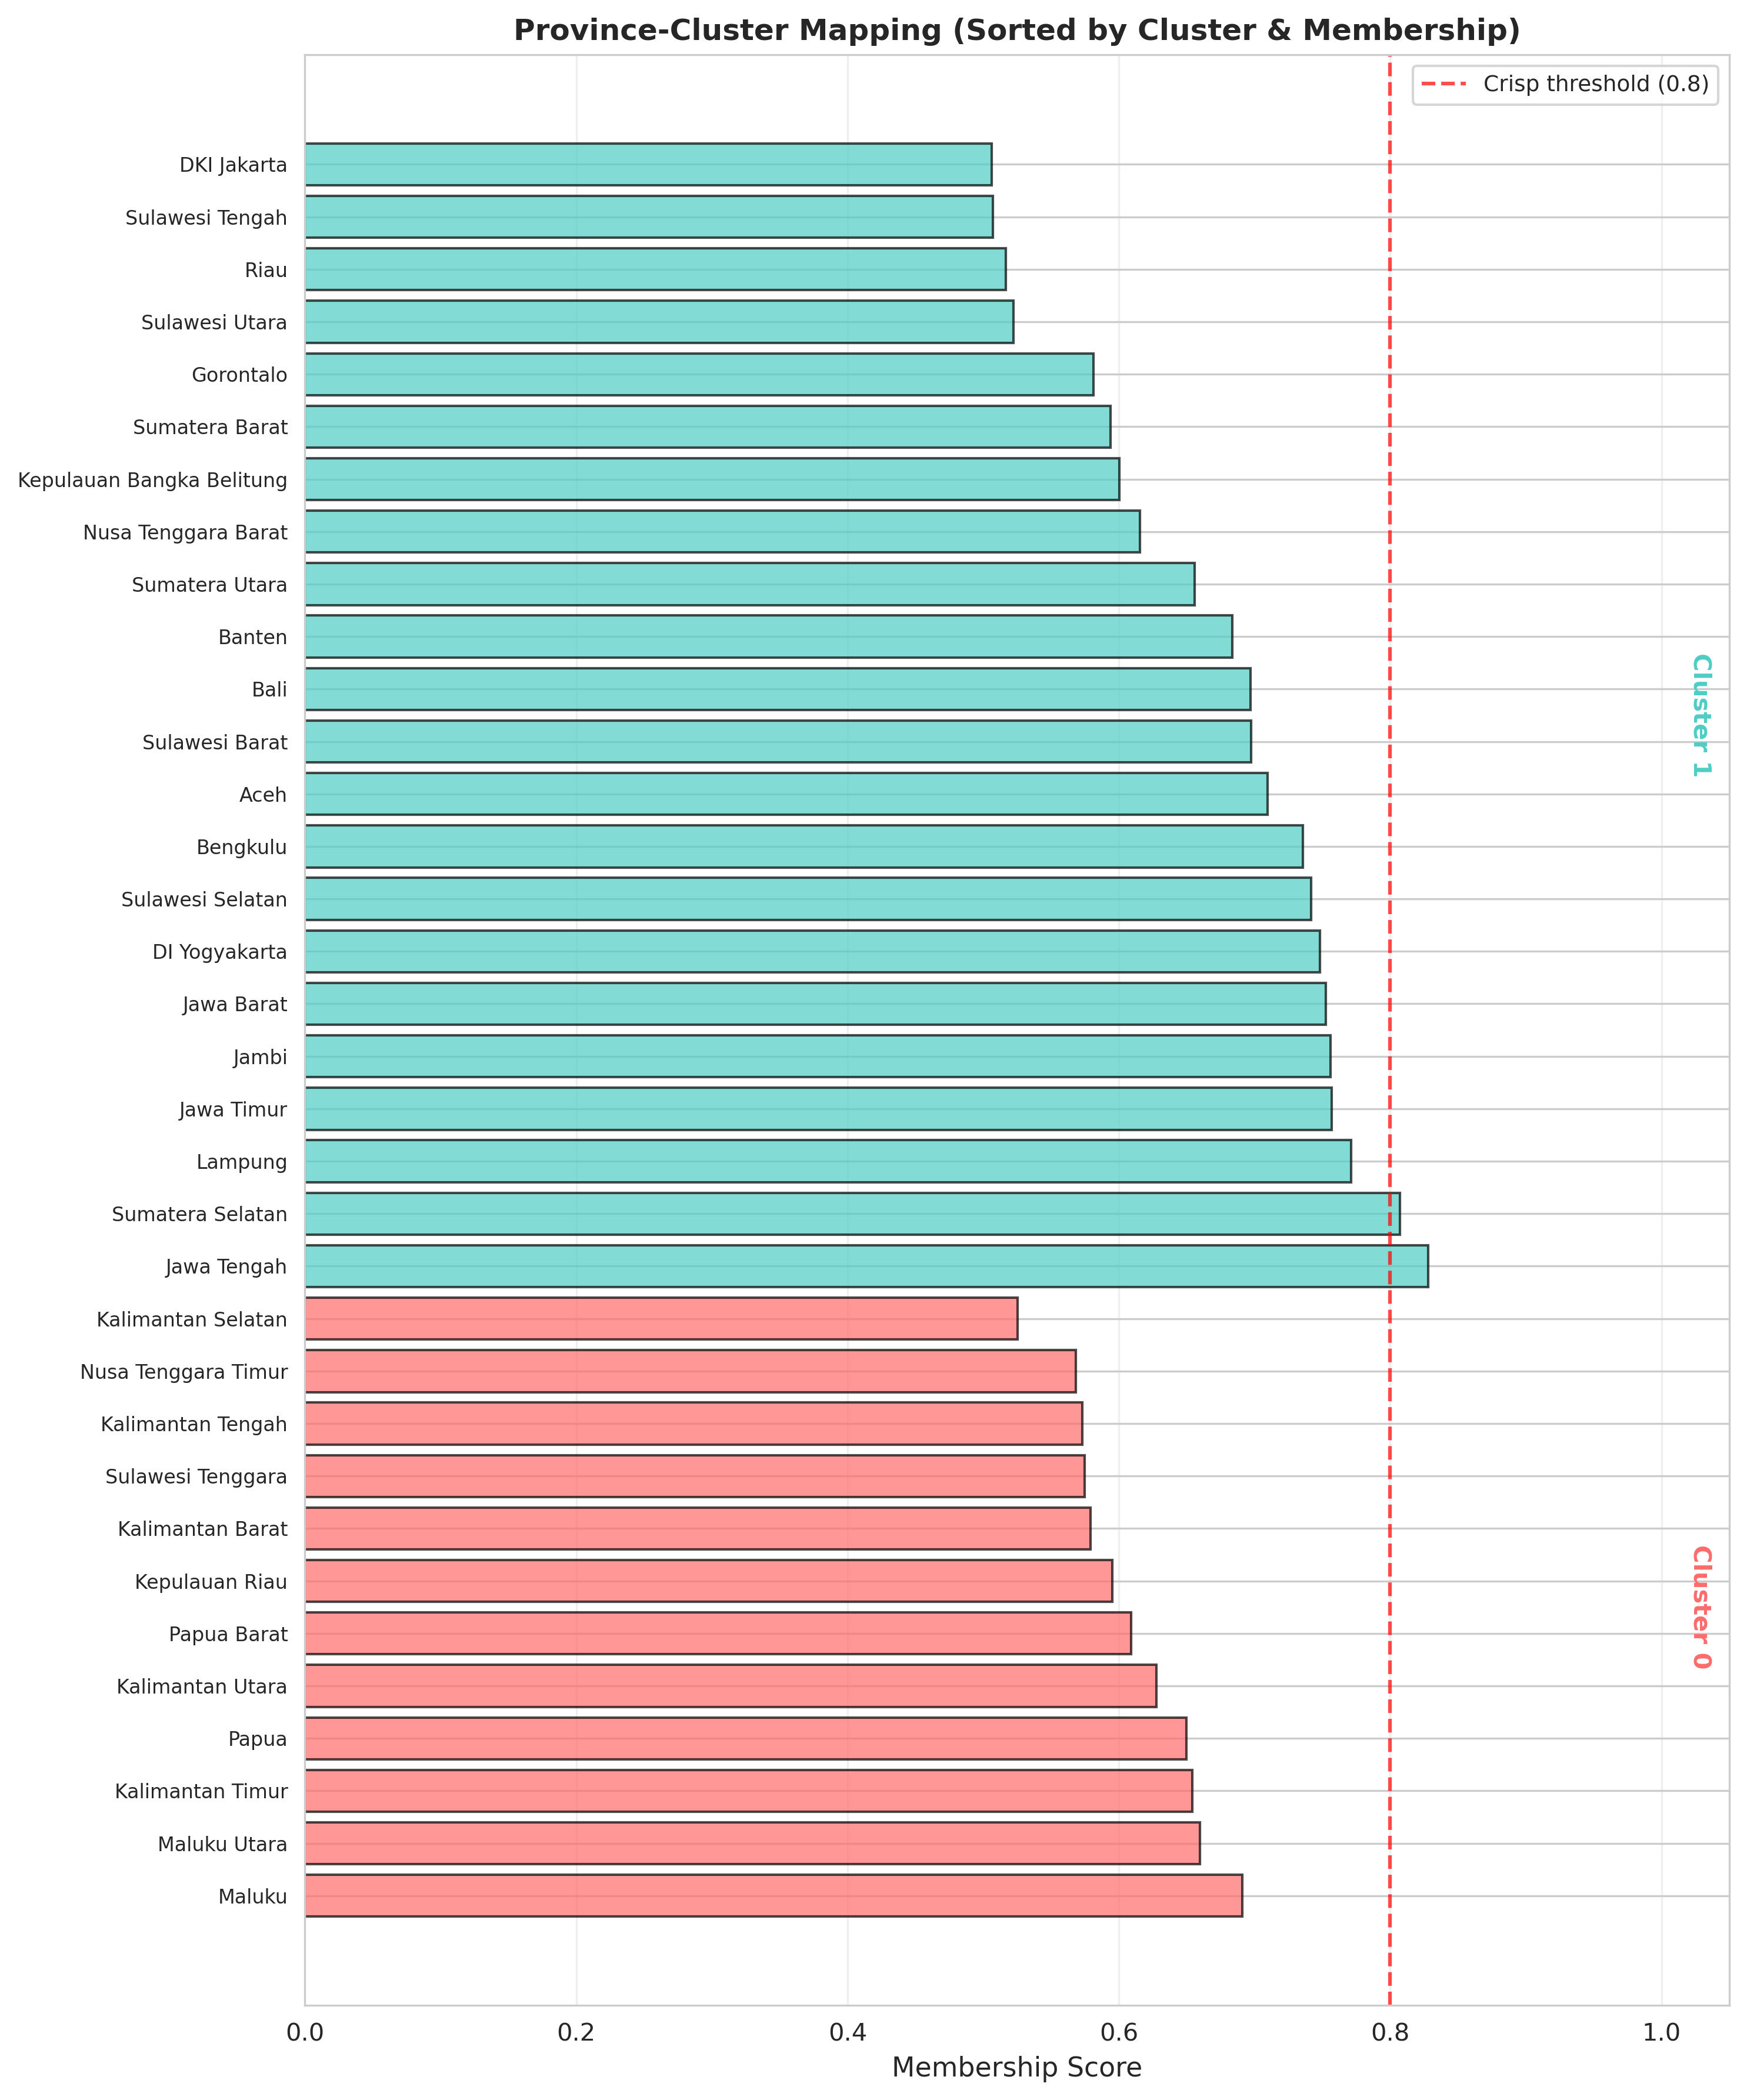

  ✓ Saved: viz_6_province_mapping.png


In [34]:
print("\n[6/7] Generating province-cluster mapping...")

fig, ax = plt.subplots(figsize=(10, 12))

# Sort provinces by cluster then by membership
province_data = []
for i, prov in enumerate(provinces):
    c_assigned = cluster_labels[i]
    mem_assigned = membership_matrix[c_assigned, i]
    province_data.append({
        'Province': prov,
        'Cluster': c_assigned,
        'Membership': mem_assigned
    })

df_prov = pd.DataFrame(province_data).sort_values(['Cluster', 'Membership'], ascending=[True, False])

y_pos = np.arange(len(df_prov))
bar_colors = [colors[c] for c in df_prov['Cluster']]

bars = ax.barh(y_pos, df_prov['Membership'], color=bar_colors, alpha=0.7, edgecolor='black')

ax.set_yticks(y_pos)
ax.set_yticklabels(df_prov['Province'], fontsize=8)
ax.set_xlabel('Membership Score', fontsize=11)
ax.set_title('Province-Cluster Mapping (Sorted by Cluster & Membership)', fontsize=12, weight='bold')
ax.set_xlim(0, 1.05)
ax.axvline(0.8, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='Crisp threshold (0.8)')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, axis='x')

# Add cluster labels
for c_id in [0, 1]:
    cluster_provs_idx = df_prov[df_prov['Cluster'] == c_id].index
    if len(cluster_provs_idx) > 0:
        y_start = y_pos[df_prov.index.get_loc(cluster_provs_idx[0])]
        y_end = y_pos[df_prov.index.get_loc(cluster_provs_idx[-1])]
        y_mid = (y_start + y_end) / 2
        
        ax.text(1.02, y_mid, f'Cluster {c_id}', 
                rotation=-90, va='center', ha='left',
                fontsize=10, weight='bold', color=colors[c_id])

plt.tight_layout()
plt.show()
plt.savefig(OUTPUT_DIR + 'viz_6_province_mapping.png', dpi=300, bbox_inches='tight')
print(f"  ✓ Saved: viz_6_province_mapping.png")
plt.close()


[7/7] Generating model evaluation metrics visualization...
  ✓ Saved: viz_7a_evaluation_metrics.png
  ✓ Saved: viz_7b_feature_importance.png


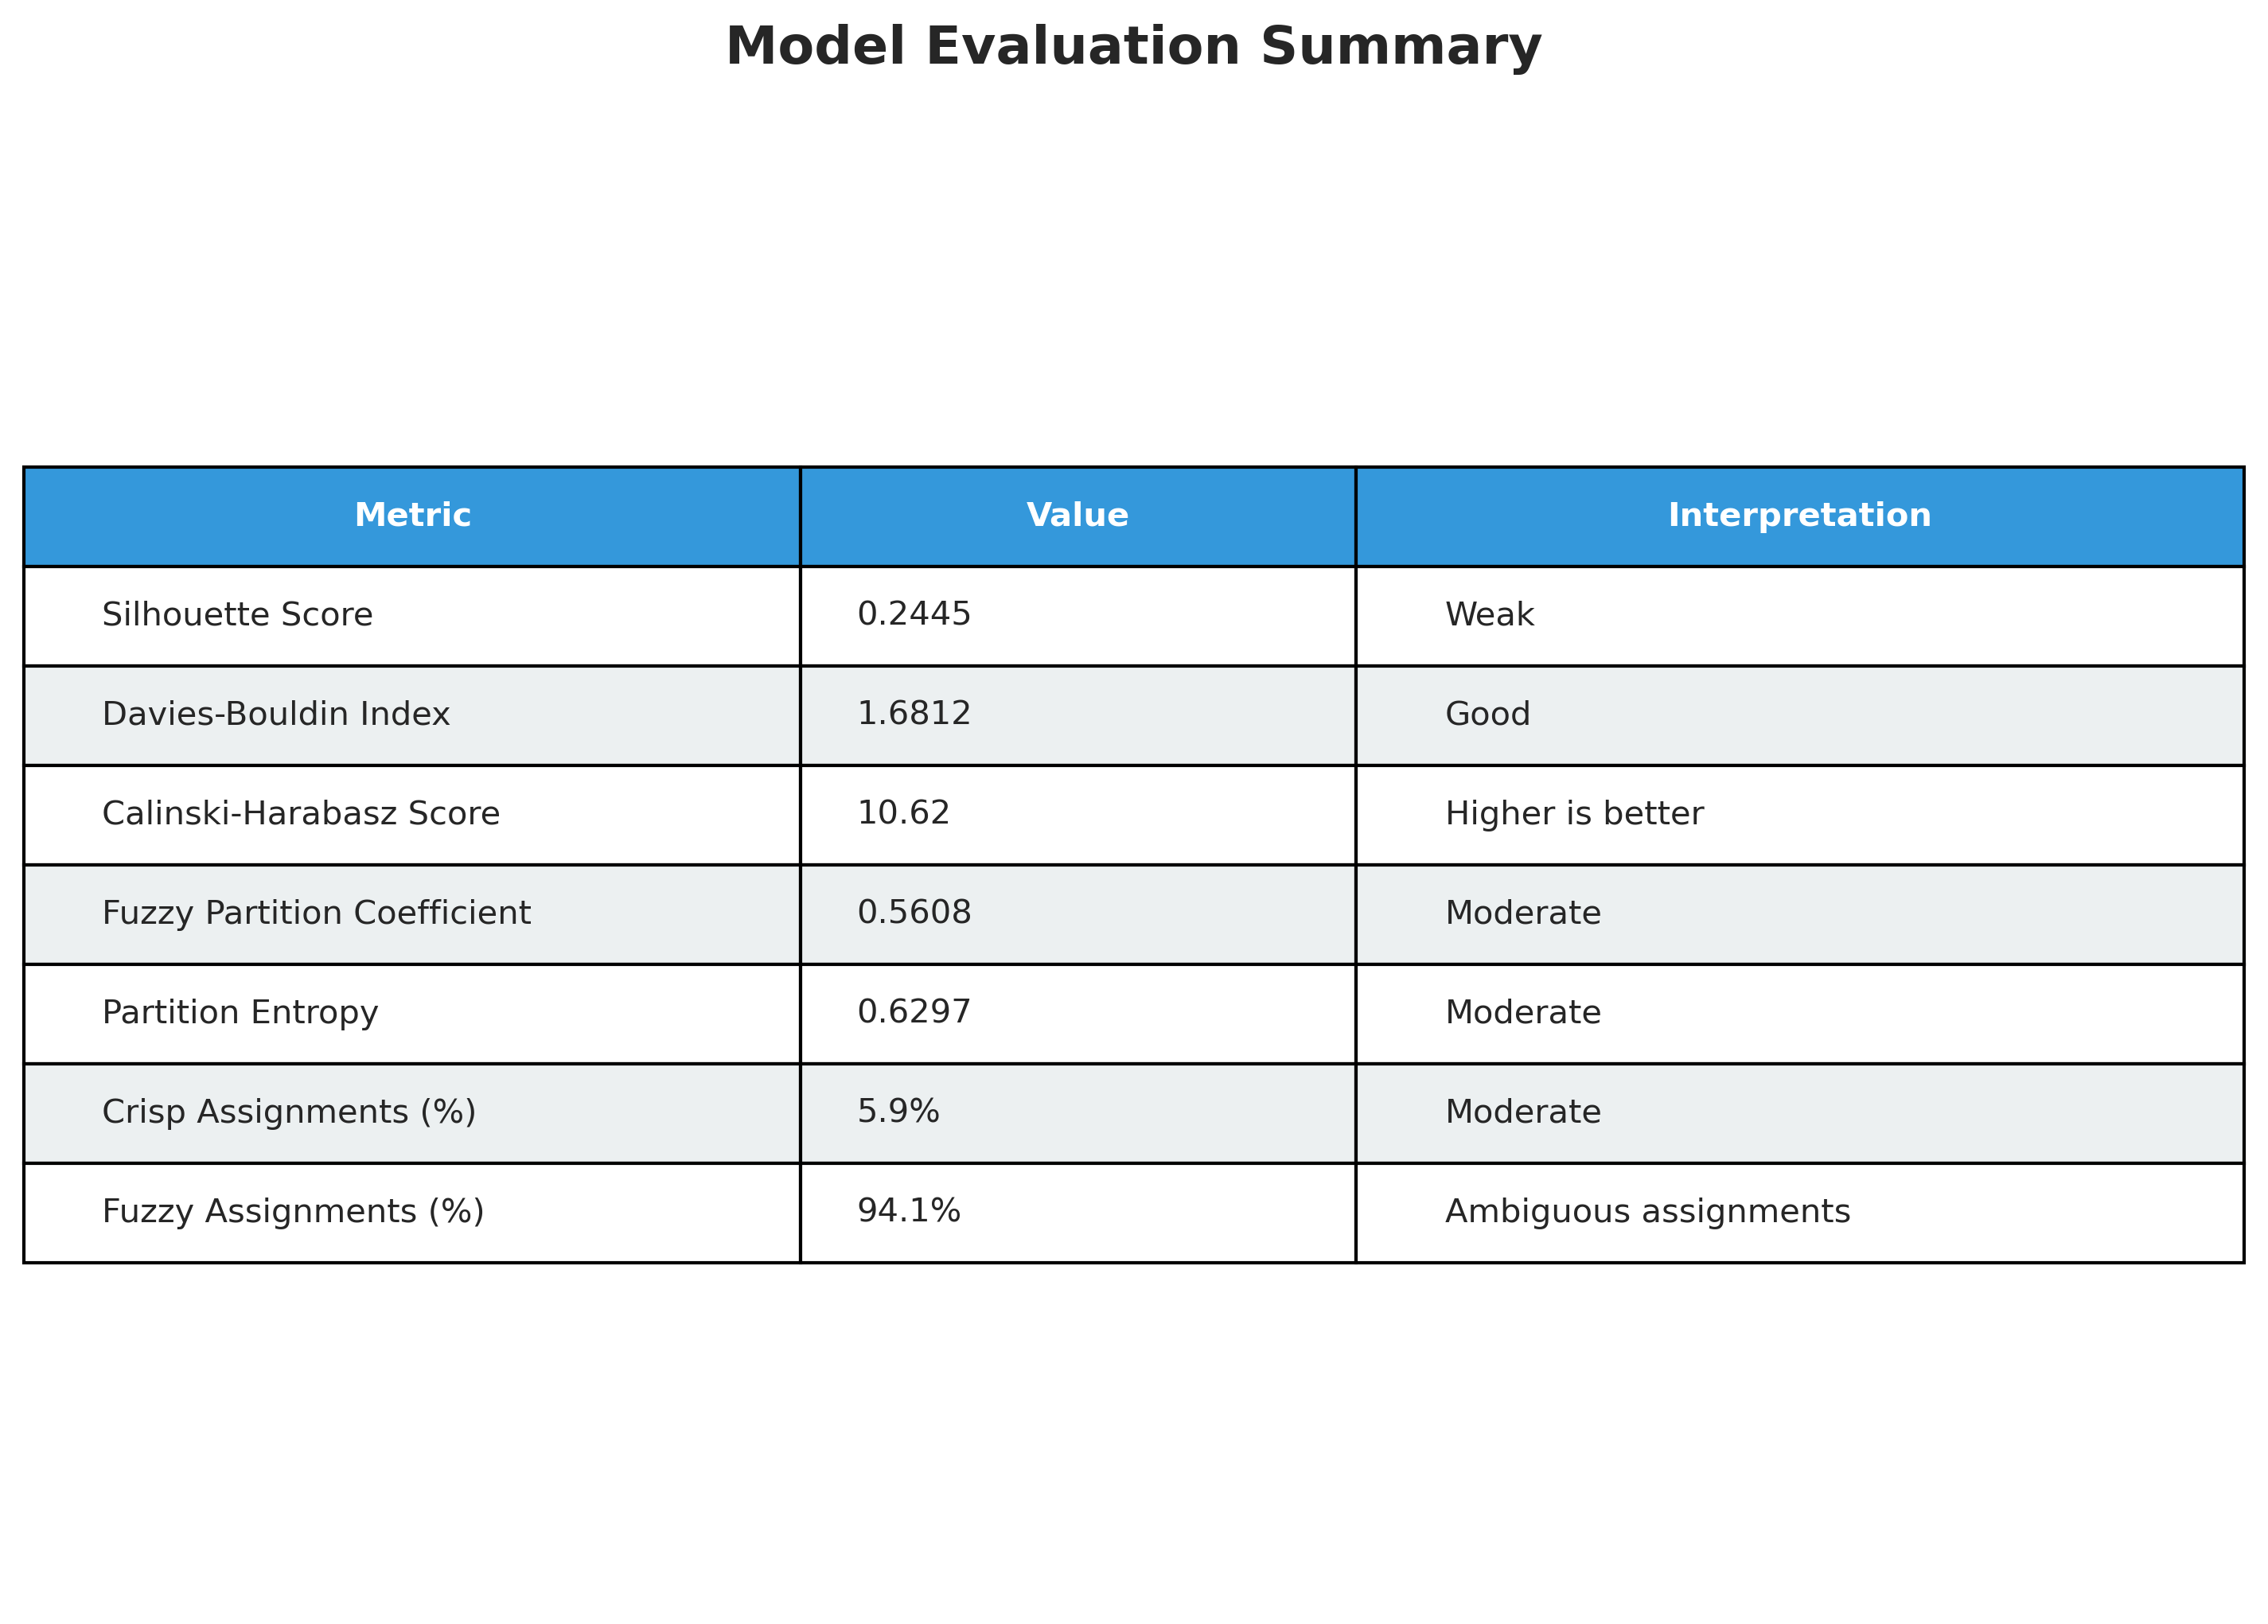

  ✓ Saved: viz_7c_evaluation_table.png

  ✅ Generated 3 evaluation visualizations:
     - viz_7a_evaluation_metrics.png (Key metrics bar charts)
     - viz_7b_feature_importance.png (Feature importance)
     - viz_7c_evaluation_table.png (Summary table)



In [39]:
# ============================================================================
# VISUALIZATION 7: MODEL EVALUATION METRICS (BAR CHARTS)
# ============================================================================
print("\n[7/7] Generating model evaluation metrics visualization...")

try:
    # Load evaluation summary
    df_eval = pd.read_csv(OUTPUT_DIR + 'model_evaluation_summary.csv')
    df_importance = pd.read_csv(OUTPUT_DIR + 'feature_importance.csv')
    
    # ========================================================================
    # 7A: KEY METRICS BAR CHART
    # ========================================================================
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Select key metrics for visualization
    key_metrics = [
        'Silhouette Score',
        'Davies-Bouldin Index',
        'Fuzzy Partition Coefficient',
        'Partition Entropy'
    ]
    
    # Extract values (remove ± parts if exist)
    metric_data = []
    for metric in key_metrics:
        row = df_eval[df_eval['Metric'] == metric]
        if not row.empty:
            value_str = row['Value'].values[0]
            # Extract numeric part (before ± or %)
            import re
            numeric = re.findall(r'[-+]?\d*\.?\d+', str(value_str))
            if numeric:
                metric_data.append({
                    'Metric': metric,
                    'Value': float(numeric[0]),
                    'Interpretation': row['Interpretation'].values[0]
                })
    
    df_key_metrics = pd.DataFrame(metric_data)
    
    # Plot 1: Silhouette Score
    ax1 = axes[0, 0]
    sil_val = df_key_metrics[df_key_metrics['Metric']=='Silhouette Score']['Value'].values[0]
    
    bars1 = ax1.barh(['Silhouette'], [sil_val], color='#2ecc71', alpha=0.8, edgecolor='black', linewidth=2)
    ax1.axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Threshold (0.0)')
    ax1.axvline(0.25, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Good (0.25)')
    ax1.set_xlim(-0.1, 1.0)
    ax1.set_xlabel('Score', fontsize=12)
    ax1.set_title('Silhouette Score\n(Higher = Better Separation)', fontsize=12, weight='bold')
    ax1.legend(fontsize=9)
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Add value label
    ax1.text(sil_val + 0.02, 0, f'{sil_val:.4f}', va='center', fontsize=11, weight='bold')
    
    # Plot 2: Davies-Bouldin Index
    ax2 = axes[0, 1]
    dbi_val = df_key_metrics[df_key_metrics['Metric']=='Davies-Bouldin Index']['Value'].values[0]
    
    bars2 = ax2.barh(['DBI'], [dbi_val], color='#e74c3c', alpha=0.8, edgecolor='black', linewidth=2)
    ax2.axvline(2.0, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Threshold (2.0)')
    ax2.axvline(1.0, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Excellent (1.0)')
    ax2.set_xlim(0, 3.0)
    ax2.set_xlabel('Index', fontsize=12)
    ax2.set_title('Davies-Bouldin Index\n(Lower = Better Separation)', fontsize=12, weight='bold')
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3, axis='x')
    
    # Add value label
    ax2.text(dbi_val + 0.05, 0, f'{dbi_val:.4f}', va='center', fontsize=11, weight='bold')
    
    # Plot 3: Fuzzy Partition Coefficient
    ax3 = axes[1, 0]
    fpc_val = df_key_metrics[df_key_metrics['Metric']=='Fuzzy Partition Coefficient']['Value'].values[0]
    
    bars3 = ax3.barh(['FPC'], [fpc_val], color='#3498db', alpha=0.8, edgecolor='black', linewidth=2)
    ax3.axvline(0.5, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='Threshold (0.5)')
    ax3.axvline(0.7, color='green', linestyle='--', linewidth=2, alpha=0.7, label='High Crisp (0.7)')
    ax3.set_xlim(0, 1.0)
    ax3.set_xlabel('Coefficient', fontsize=12)
    ax3.set_title('Fuzzy Partition Coefficient\n(Higher = More Crisp)', fontsize=12, weight='bold')
    ax3.legend(fontsize=9)
    ax3.grid(True, alpha=0.3, axis='x')
    
    # Add value label
    ax3.text(fpc_val + 0.02, 0, f'{fpc_val:.4f}', va='center', fontsize=11, weight='bold')
    
    # Plot 4: Partition Entropy
    ax4 = axes[1, 1]
    pe_val = df_key_metrics[df_key_metrics['Metric']=='Partition Entropy']['Value'].values[0]
    max_entropy = np.log(2)
    
    bars4 = ax4.barh(['PE'], [pe_val], color='#9b59b6', alpha=0.8, edgecolor='black', linewidth=2)
    ax4.axvline(max_entropy, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Max Entropy ({max_entropy:.3f})')
    ax4.axvline(max_entropy * 0.5, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Low Entropy')
    ax4.set_xlim(0, max_entropy * 1.1)
    ax4.set_xlabel('Entropy', fontsize=12)
    ax4.set_title('Partition Entropy\n(Lower = More Crisp)', fontsize=12, weight='bold')
    ax4.legend(fontsize=9)
    ax4.grid(True, alpha=0.3, axis='x')
    
    # Add value label
    ax4.text(pe_val + 0.02, 0, f'{pe_val:.4f}', va='center', fontsize=11, weight='bold')
    
    plt.suptitle('FCM Model Evaluation: Key Metrics', fontsize=16, weight='bold')
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR + 'viz_7a_evaluation_metrics.png', dpi=300, bbox_inches='tight')
    print(f"  ✓ Saved: viz_7a_evaluation_metrics.png")
    plt.close()
    
    # ========================================================================
    # 7B: FEATURE IMPORTANCE (HORIZONTAL BAR CHART)
    # ========================================================================
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Sort by absolute Cohen's d
    df_importance_sorted = df_importance.sort_values('cohens_d', key=abs, ascending=True)
    
    # Color by significance
    colors_sig = []
    for sig in df_importance_sorted['significance']:
        if sig == '***':
            colors_sig.append('#27ae60')  # Green
        elif sig == '**':
            colors_sig.append('#f39c12')  # Orange
        elif sig == '*':
            colors_sig.append('#e67e22')  # Dark orange
        else:
            colors_sig.append('#95a5a6')  # Gray
    
    bars = ax.barh(df_importance_sorted['Feature_Type'], 
                   df_importance_sorted['cohens_d'].abs(),
                   color=colors_sig, alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Add value labels
    for i, (idx, row) in enumerate(df_importance_sorted.iterrows()):
        value = abs(row['cohens_d'])
        ax.text(value + 0.01, i, f"{value:.3f} {row['significance']}", 
                va='center', fontsize=10, weight='bold')
    
    ax.set_xlabel("Effect Size (|Cohen's d|)", fontsize=12)
    ax.set_ylabel('Feature Type', fontsize=12)
    ax.set_title("Feature Importance for Cluster Separation\n(Effect Size & Statistical Significance)", 
                 fontsize=13, weight='bold', pad=15)
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add legend for significance
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#27ae60', label='*** (p < 0.001)'),
        Patch(facecolor='#f39c12', label='** (p < 0.01)'),
        Patch(facecolor='#e67e22', label='* (p < 0.05)'),
        Patch(facecolor='#95a5a6', label='ns (not significant)')
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=9, title='Significance')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR + 'viz_7b_feature_importance.png', dpi=300, bbox_inches='tight')
    print(f"  ✓ Saved: viz_7b_feature_importance.png")
    plt.close()
    
    # ========================================================================
    # 7C: EVALUATION SUMMARY TABLE (TEXT VISUALIZATION)
    # ========================================================================
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.axis('tight')
    ax.axis('off')
    
    # Prepare table data (select key metrics)
    table_metrics = [
        'Silhouette Score',
        'Davies-Bouldin Index',
        'Calinski-Harabasz Score',
        'Fuzzy Partition Coefficient',
        'Partition Entropy',
        'Crisp Assignments (%)',
        'Fuzzy Assignments (%)'
    ]
    
    table_data = []
    for metric in table_metrics:
        row = df_eval[df_eval['Metric'] == metric]
        if not row.empty:
            table_data.append([
                metric,
                row['Value'].values[0],
                row['Interpretation'].values[0]
            ])
    
    # Create table
    table = ax.table(cellText=table_data,
                     colLabels=['Metric', 'Value', 'Interpretation'],
                     cellLoc='left',
                     loc='center',
                     colWidths=[0.35, 0.25, 0.4])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2.5)
    
    # Style header
    for i in range(3):
        table[(0, i)].set_facecolor('#3498db')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Style rows
    for i in range(1, len(table_data) + 1):
        if i % 2 == 0:
            for j in range(3):
                table[(i, j)].set_facecolor('#ecf0f1')
    
    ax.set_title('Model Evaluation Summary', fontsize=16, weight='bold', pad=20)
    
    plt.tight_layout
    plt.show()
    plt.savefig(OUTPUT_DIR + 'viz_7c_evaluation_table.png', dpi=300, bbox_inches='tight')
    print(f"  ✓ Saved: viz_7c_evaluation_table.png")
    plt.close()
    
    print("\n  ✅ Generated 3 evaluation visualizations:")
    print("     - viz_7a_evaluation_metrics.png (Key metrics bar charts)")
    print("     - viz_7b_feature_importance.png (Feature importance)")
    print("     - viz_7c_evaluation_table.png (Summary table)")
    
except FileNotFoundError as e:
    print(f"  ⚠️ Error: {e}")
    print(f"  ⚠️ Make sure model_evaluation_summary.csv and feature_importance.csv exist in {OUTPUT_DIR}")
except Exception as e:
    print(f"  ⚠️ Unexpected error: {e}")
    import traceback
    traceback.print_exc()

print("\n" + "="*80)
